## Complete Hathi data

We ran the extraction runs against the complete set of 4.8 million volumes in the HTRC extracted features data. On the Sherlock cluster, this took about 10 hours in total (not counting time spent in the queue). The jobs observed a total of just over 300 billion tokens:

In [1]:
from hol.models import Count, AnchoredCount

print(Count.total_token_count())

301153186521


The overall volume trends looks pretty similar to the Harvard subset that we used in the first go-around:

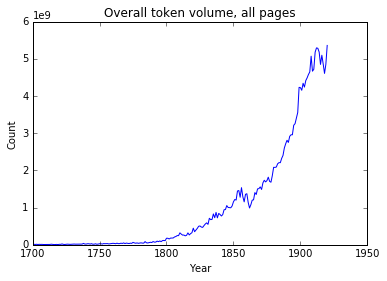

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

series = Count.year_count_series(1700, 1920)

plt.title('Overall token volume, all pages')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))

But, the X-axis units here are in 100-millions, so in an absolute sense even the thin little ribbon on the left side of the plot in C18 is still a pretty large amount of data. Here's just the 18th century:

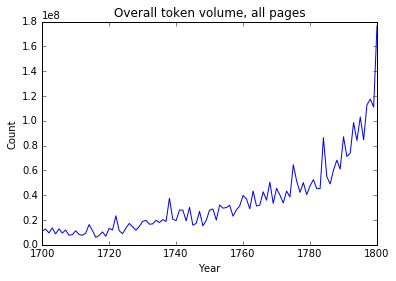

In [3]:
series = Count.year_count_series(1700, 1800)

plt.title('Overall token volume, all pages')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))

So, in 1780, we saw in the neighborhood of 50M tokens, which is a pretty respectable number.

### Page grouping

Behind the scenes, I also made some changes to the mechanics of how we collect the counts for the "literture" pages before firing off the jobs on Sherlock. The big problem I wanted to address was the change in page size over time. I looked at the average page counts in the corpus for different periods, and found, as you'd expect, that it changes pretty significantly over time. In the 18th centry, many of the volumes are physically small, and have just 1-200 words per page, whereas it's common to see anywhere from 200 to about 400 on the way through C19. This means that, if we don't account for this, we're essentially taking a different sample from the earlier parts of the corpus than the later ones - we're taking a broader "field" around literature in 1820 than 1920.

This is a little awkward in the context of the HTRC data set because we only have page-level counts - we don't have the original sequence of tokens in the texts, so we can't just go in and shift around the page boundaries to make them even. What we can do, though, is to look at the total token counts on each page in a volume and group them together so that they _average_ out to a fixed number of tokens in length. For example, say we've got a volume that has 10 pages in it, each 400 words long:

In [4]:
pages = [400] * 10
print(pages)

[400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


And, say that we want to group the pages together so that they average out to blocks of 500 words. We can do this:

In [5]:
from hol.utils import group_counts

print(group_counts(pages, 1000))

[[400, 400, 400], [400, 400], [400, 400], [400, 400, 400]]


For every page in the volume, the algorithm just checks to see if adding the page to the most recent group will get the overall average length of all the groups closer to the requested size. If so, the page gets added to the group, and if not it's broken off into a new group. Spread out over hundreds of pages and millions of volumes, that means that we can take counts for "literature" from groups of words that average out almost exactly to a requested chunk size. Eg, say we've got a 500 page book, with pages ranging from 200 to 400 words in length:

In [6]:
import random

pages = [random.randint(200, 400) for _ in range(500)]

groups = group_counts(pages, 1000)

# Get the average token count of the groups.
avg_length = sum(map(sum, groups)) / len(groups)

print(avg_length)

996.6556291390729


We end up with chunks that are almost exactly 1000 words long.

### Words-per-million series

When I plugged the full-size data set into the extraction code and started testing out different ideas and intuitions, I realized that the way I was modeling the "trends" of different words - looking at their rank position in MDW lists over time - had some shortcomings. This was good at identifying changes in the cream of the crop, as it were - turnover at the very top of the lists, in the set of words most extremely asociated with "literature" at any given point in time. But, as I started to take a wider view on the question, I realized that it wasn't as good at picking up on more subtle changes in words further down in the stack. For example, if you skim off a fairly large number of words off the tops of the MDW lists - say, 1000 - and track how different words move around on on these "deep" lists, you end up with time series that, once again, often look quite similar to the overall volume trend for the word at hand.

Instead of trying to find (another) way to compensate for this, I decided just to explicitly structure the analysis around dispatching with this problem. This ended up taking me in a direction that's much simpler, and I think also much more interperable.

### Raw WPM series

The bread and butter of it is just the raw words-per-million trends for each word. Eg, for "jesus" - the blue line is the words-per-million trend on all pages in the corpus, and the green line is the trend for "jesus" just on page groups that contain "literature":

In [7]:
from hol.count_wpm import CountWPM
from hol.anchored_count_wpm import AnchoredCountWPM

year1 = 1760
year2 = 1920

wpm0 = CountWPM(year1, year2)
wpm1 = AnchoredCountWPM(year1, year2)

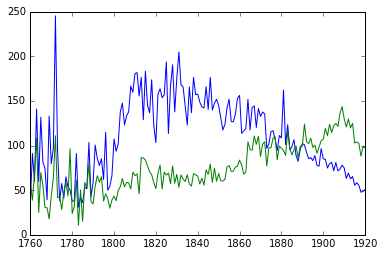

In [8]:
series = wpm0.series('jesus')
plt.plot(*zip(*series.items()))

series = wpm1.series('jesus')
plt.plot(*zip(*series.items()))

### Smoothed WPM series

These can be smoothed down using a Savgol filter, which is a step up from the simple convolution / moving average, which can produce some erratic effects around the edges that throw off the time series analysis on the far end end of things. Jesus again, smoothed down:

-0.159735300311 0.0429664162205


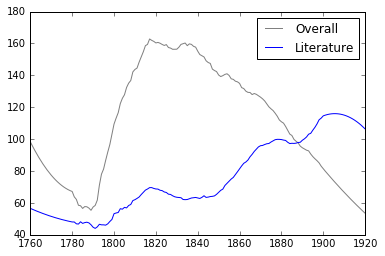

In [9]:
from collections import OrderedDict
from scipy.stats import pearsonr

def plot_token(token):

    s1 = wpm0.series_smooth(token)
    plt.plot(*zip(*s1.items()), label='Overall', color='gray')

    s2 = wpm1.series_smooth(token)
    plt.plot(*zip(*s2.items()), label='Literature')
    
    plt.legend(loc='upper right')
    
    s1_resized = OrderedDict([
        (year, s1[year])
        for year in s2.keys()
    ])
    
    vals1 = list(s1_resized.values())
    vals2 = list(s2.values())
    
    corr, p = pearsonr(vals1, vals2)
    print(corr, p)
    
plot_token('jesus')

The gray line is basically the expected value - under a null hypothesis, in which there's no relationship between "literature" and "jesus," we'd expect the blue line to be the same as the gray line. Indeed, with "the":

0.870859052536 6.55550433858e-51


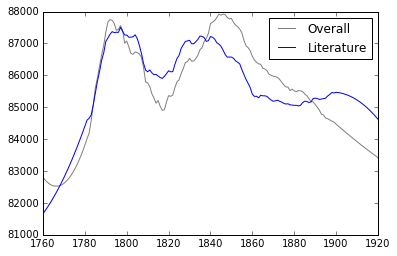

In [10]:
plot_token('the')

(Note that the Y-axis is fit around the data, here, so even where it looks like there's a divergence - eg, in 1810 - it's really only about a 1% difference, whereas the difference for "jesus" in 1810 is about 260%).

These plots contain all the information we need to formalize the question of whether a word appears alongside literature at the expected rate. For example, in 1900 - "jesus" is showing up on pages with "literature" at a rate of about 120 words-per-million. But, just looking at the overall frequency of "jesus" on all pages, we'd expect that it would show up about 80 times-per-million. Since the units here are the same, we can just say that "jesus" is appearing with "literature" about about 1.5 times the rate we'd expect. This can be generalized across the entire X-axis by just dividing the MPW series for "literature" pages by the series for all pages.

As a first step, though, let's get a constrained set of words to work with. To get words that have been associated with literature at one point or another, we can just step through a series of 20-year intervals, find the MDWs with literature for that period, skim off the top 1,000 words from these lists, and combine them into a single set:

In [11]:
from hol.models import AnchoredCount

buckets = [
    (1760, 1780),
    (1780, 1800),
    (1800, 1820),
    (1820, 1840),
    (1840, 1860),
    (1860, 1880),
    (1880, 1900),
    (1900, 1920),
]

tokens = set()

for y1, y2 in buckets:
    mdws = AnchoredCount.mdw(y1, y2)
    tokens.update(list(mdws.keys())[:1000])

Which gives us a working set of about 1800 words.

In [12]:
print(len(tokens))

1855


In [13]:
import numpy as np

ratios = {}
for token in tokens:
    
    s1 = wpm0.series_smooth(token)
    s2 = wpm1.series_smooth(token)
    
    s1_resized = OrderedDict([
        (year, s1[year])
        for year in s2.keys()
    ])
    
    vals1 = list(s1_resized.values())
    vals2 = list(s2.values())
    
    r = np.array(vals2) / np.array(vals1)
    
    ratios[token] = OrderedDict(zip(s2.keys(), r))

### Divide "literature" WPMs by overall WPMs

Now, we can step through each of these tokens and:

- Get the words-per-million series for the token (a) on pages with literature and (b) on all pages.
- Divide each element of a by the corresponding element in b.

This gives us a single time series that captures difference between the two. For "jesus":

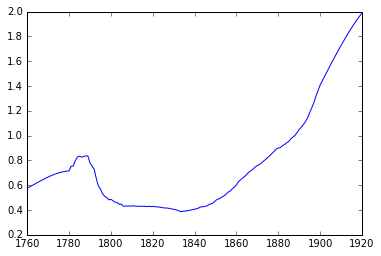

In [14]:
plt.plot(*zip(*ratios['jesus'].items()))

Where the X-axis can be read directly - 1.0 means that word shows up with literature at exactly the rate that would be predicted by the overall frequency of the word. And, for "jesus" - in 1920, it shows up 2x as frequently as would have been expected, and so on and so forth.

### "Volatile" or "dynamic" words

Now, with this in hand, we can map "query" functions across all of these time series to find words of interest. I started out by looking at words that have the largest declines over time - that have the largest overall gaps between 1760 and 1920. By and large, these fall into a couple of interesting groups.

First, a cluster of words that seem to hang together around a notion of _expertise_ - skill, excellence, the display of acuity or competence:

In [15]:
import math

def print_ratios(tokens, cols=5):
    
    # Get row count and figure size.
    rows = math.ceil(len(tokens) / cols)
    figsize = (cols*2, rows*2)
    
    # Make the figure + axes.
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout(pad=0, h_pad=2, w_pad=0.1)
    
    for i, token in enumerate(tokens):
        
        ax = axarr[math.floor(i/cols)][i%cols]
        ax.set_title(token)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
        ax.tick_params(labelsize=8)
        ax.set_xlim(year1, year2)
        
        s = ratios[token]
        
        ax.plot(
            *zip(*s.items()),
            linestyle='none',
            marker='.',
            markersize=2,
        )

### Excellence

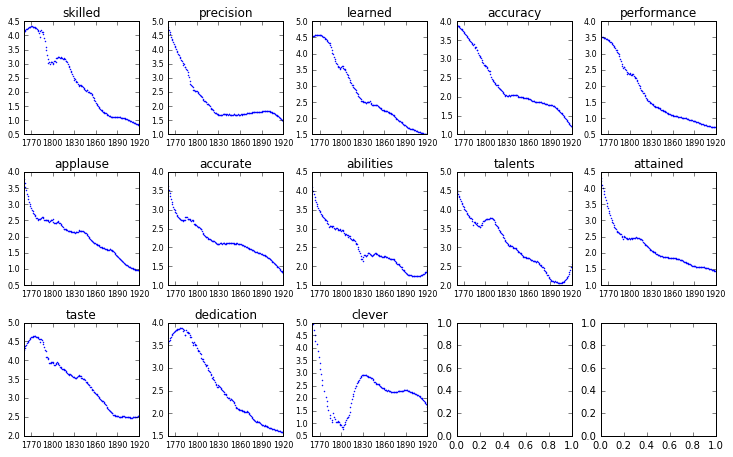

In [16]:
print_ratios([
    'skilled',
    'precision',
    'learned',
    'accuracy',
    'performance',
    'applause',
    'accurate',
    'abilities',
    'talents',
    'attained',
    'taste',
    'dedication',
    'clever',
])

Related but distinct, a set of words that orbit around the usefulness or utility of literature, the direct, personal value it might afford to the reader:

### Usefulness

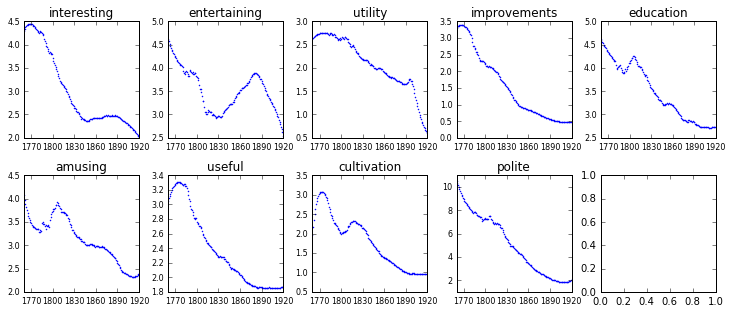

In [17]:
print_ratios([
    'interesting',
    'entertaining',
    'utility',
    'improvements',
    'education',
    'amusing',
    'useful',
    'cultivation',
    'polite',
])

By far the largest conceptual group that declines over time, though, are words related to education:

### Education

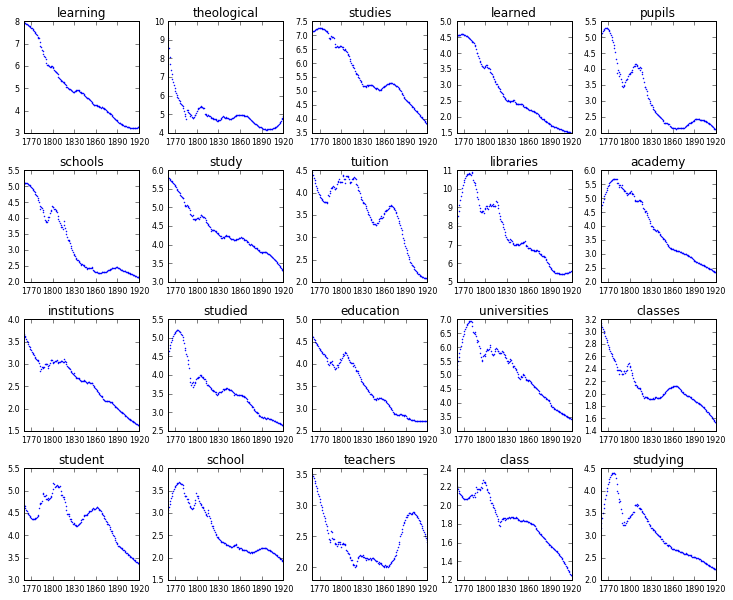

In [18]:
print_ratios([
    'learning',
    'theological',
    'studies',
    'learned',
    'pupils',
    'schools',
    'study',
    'tuition',
    'libraries',
    'academy',
    'institutions',
    'studied',
    'education',
    'universities',
    'classes',
    'student',
    'school',
    'teachers',
    'class',
    'studying',
])

Science also trends down, though with some interesting fits and starts. What's up with "mathematics"?

### Science

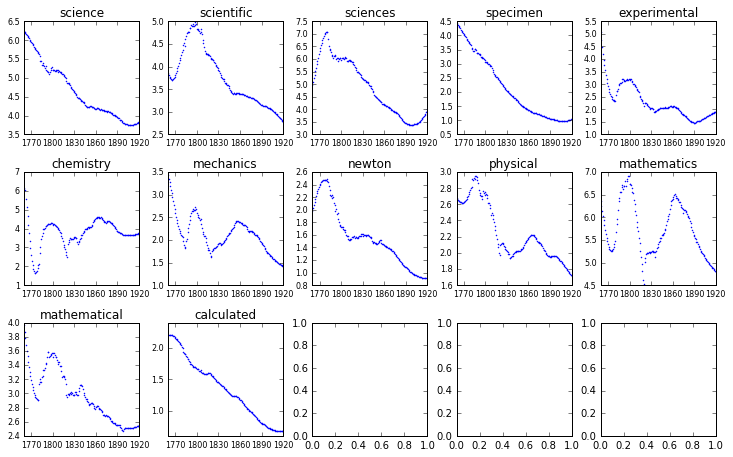

In [19]:
print_ratios([
    'science',
    'scientific',
    'sciences',
    'specimen',
    'experimental',
    'chemistry',
    'mechanics',
    'newton',
    'physical',
    'mathematics',
    'mathematical',
    'calculated',
])

If literature drifts away from education and science over the course of the long 19th century, then it moves towards religion, which figure really prominently on the list of words that have the largest increases over time:

### Religion

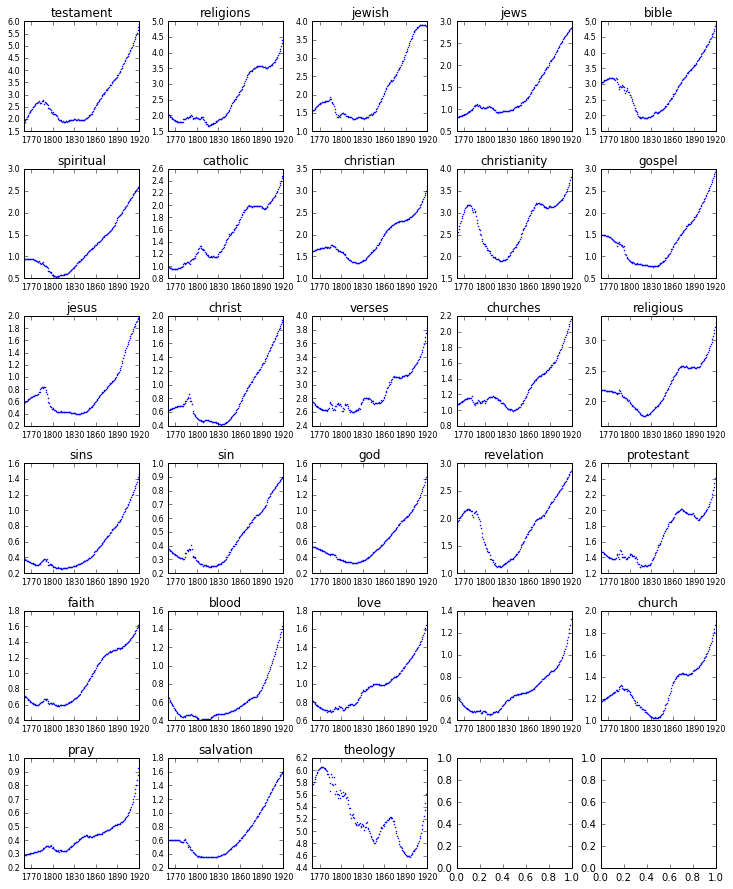

In [ ]:
print_ratios([
    'testament',
    'religions',
    'jewish',
    'jews',
    'bible',
    'spiritual',
    'catholic',
    'christian',
    'christianity',
    'gospel',
    'jesus',
    'christ',
    'verses',
    'churches',
    'religious',
    'sins',
    'sin',
    'god',
    'revelation',
    'protestant',
    'faith',
    'blood',
    'love',
    'heaven',
    'church',
    'pray',
    'salvation',
    'theology',
])

Though it's interesting to note that the one exception to this is the one academically-inflected word - theology, last in the figure - which, sure enough, declines along with the education words above.

Meanwhile, there's also an increase in words that might fall under the rubric of literary taxonomy - words used to classify literature, to slice and dice it into different buckets. It's the rise of literature a concept, something that calls for description, labels, structure.

### Literary taxonomy, format

In [ ]:
print_ratios([
    'epic',
    'essays',
    'fiction',
    'prose',
    'romantic',
    'contemporary',
    'poetry',
    'verse',
    'narrative',
    'humor',
    'subjects',
    'tale',
    'tales',
    'magazines',
    'journals',
    'novel',
    'novels',
    'classics',
])

Only "classics" declines, though it also starts to tick back up noticeably around 1900. Along the same lines literature starts to get bucketed by author and provenance, along demographic lines - ethnicities, languages, nationalities, and places:

### Demographics

In [ ]:
print_ratios([
    'latin',
    'jews',
    'jewish',
    'celtic',
    'hebrew',
    'english',
    'edinburgh',
    'israel',
    'spanish',
    'greeks',
    'russian',
    'scottish',
    'french',
    'america',
    'greek',
    'venice',
    'nation',
    'england',
    'universal',
])

Indeed, literature becomes less "universal" - more situated, spatialized?

There's lots to comment about here (see the appendix for the full lists of the top 300 words for different query patterns). But one last tidbit - there are times where these trend lines seem to surface interesting differences between seeminly minor variations of the same word. For example, "taste" fares poorly in C19:

In [ ]:
plt.title('taste')
plt.plot(*zip(*ratios['taste'].items()))

But "tastes" has a very different trend, spiking dramatically around 1800:

In [ ]:
plt.title('tastes')
plt.plot(*zip(*ratios['tastes'].items()))

What is this? I'd guess: it's "taste" in the boolean sense of the idea - something you have or don't have, something your can exhibit by reading books of a certain kind and not another. Whereas "tastes," plural, works more like perferences or predilections, in the sense of - "I like science fiction, but not fantasy."